In [1]:
!git clone https://github.com/emanhamed/Houses-dataset
!git clone https://github.com/vcadillog/Ensemble-Network-House
!pip install wandb -qU

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (2144/2144), done.
Cloning into 'Ensemble-Network-House'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 78 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (78/78), 17.39 KiB | 211.00 KiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.2 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
import sys
sys.path.append('./Ensemble-Network-House/utils')
from learning import run,set_seed, data_transforms
from dataset import CustomDataset

import pandas as pd
import cv2
import os
import numpy as np

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from torchvision.transforms import Normalize, ToPILImage
from torch.utils.data import DataLoader

set_seed(42)

In [3]:

filename = './Houses-dataset/Houses Dataset/HousesInfo.txt'
df = pd.read_csv(filename, sep = " ", names = ['Bedrooms','Bathrooms','Area','Zipcode','Price'])


In [ ]:
df

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [ ]:
df.dtypes

Bedrooms       int64
Bathrooms    float64
Area           int64
Zipcode        int64
Price          int64
dtype: object

In [ ]:
print('Numbers of different Zipcode: ',len(df.groupby('Zipcode').count()))
print('Numbers of different Area: ',len(df.groupby('Area').count()))

Numbers of different Zipcode:  49
Numbers of different Area:  435


In [ ]:

# Define the directory path and matching suffix
dir_path ='/content/Houses-dataset/Houses Dataset'
# Iterate over all files in the directory
img_sizes = []

file_list = os.listdir(dir_path)
num_files = len(file_list)
print("Number of files: ",num_files)

for i in range(1,round(num_files/4)+1):
  suffix = str(i)+"_"
  image_counter = 0
  for filename in os.listdir(dir_path):
      # Check if the file has the matching suffix
      
      if filename.startswith(suffix):
        image_counter += 1

        img_sizes.append(cv2.imread(os.path.join(dir_path, filename)).shape)
  if image_counter != 4:
    print('Number of images: {0:1d} for datapoint: {1:3d}'.format(image_counter,i))
 

Number of files:  2141


In [ ]:

img_sizes_arr = np.array(img_sizes)


mean_height = np.mean(img_sizes_arr[:, 0]) # Mean of the height dimension
std_height = np.std(img_sizes_arr[:, 0]) # Standard deviation of the height dimension
min_height = np.min(img_sizes_arr[:, 0]) # Minimum of the height dimension
max_height = np.max(img_sizes_arr[:, 0]) # Maximum of the height dimension

mean_width = np.mean(img_sizes_arr[:, 1]) # Mean of the width dimension
std_width = np.std(img_sizes_arr[:, 1]) # Standard deviation of the width dimension
min_width = np.min(img_sizes_arr[:, 1]) # Minimum of the width dimension
max_width = np.max(img_sizes_arr[:, 1]) # Maximum of the width dimension

print("Mean height: ", mean_height)
print("Standard deviation height: ", std_height)
print("Minimum height: ", min_height)
print("Maximum height: ", max_height)
print("Mean width: ", mean_width)
print("Standard deviation width: ", std_width)
print("Minimum width: ", min_width)
print("Maximum width: ", max_width)



Mean height:  573.0135514018691
Standard deviation height:  135.1872336210654
Minimum height:  187
Maximum height:  1484
Mean width:  802.3850467289719
Standard deviation width:  190.37931482888953
Minimum width:  240
Maximum width:  1484


In [4]:
oh_encoder = OneHotEncoder()
rs_encoder = RobustScaler()

X_rs = rs_encoder.fit_transform(df[['Bedrooms','Bathrooms','Area']])
X_oh = oh_encoder.fit_transform(df[['Zipcode']]).toarray()


X = np.concatenate([X_rs, X_oh],axis = 1)
y = df['Price']/df['Price'].max()

In [7]:
dummy_dataset = CustomDataset(mode='ensemble',meta = X,dir_path = '/content/Houses-dataset/Houses Dataset', y = y, transform= data_transforms(visualize = True))
batch_size = 64


dummy_dataloader = DataLoader(dummy_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)

dummy_meta, dummy_img, dummy_target = next(iter(dummy_dataloader))

print(f"Feature batch shape: {dummy_meta.size()}")
print(f"Image batch shape: {dummy_img.size()}")
print(f"Regression batch shape: {dummy_target.size()}")

Feature batch shape: torch.Size([64, 52])
Image batch shape: torch.Size([64, 3, 200, 200])
Regression batch shape: torch.Size([64])


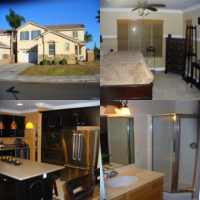

In [8]:
ToPILImage()(dummy_img[42])


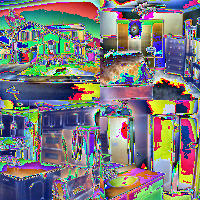

In [9]:
norm_transform = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
transform_img = norm_transform(dummy_img[42])
ToPILImage()(transform_img)

In [ ]:
# META DATA KFOLD 
run('meta', X,y, num_epochs = 25, batch_size = 32, num_folds = 5)

wandb: Currently logged in as: vcadillo. Use `wandb login --relogin` to force relogin


Fold 1
Epoch 1: train_loss=0.1004, val_loss=0.0101
Epoch 2: train_loss=0.0603, val_loss=0.0148
Epoch 3: train_loss=0.0753, val_loss=0.0223
Epoch 4: train_loss=0.0532, val_loss=0.0366
Epoch 5: train_loss=0.0541, val_loss=0.0432
Epoch 6: train_loss=0.0645, val_loss=0.0398
Epoch 7: train_loss=0.0442, val_loss=0.0312
Epoch 8: train_loss=0.0492, val_loss=0.0434
Epoch 9: train_loss=0.0445, val_loss=0.0269
Epoch 10: train_loss=0.0390, val_loss=0.0310
Epoch 11: train_loss=0.0447, val_loss=0.0316
Epoch 12: train_loss=0.0403, val_loss=0.0308
Epoch 13: train_loss=0.0421, val_loss=0.0288
Epoch 14: train_loss=0.0413, val_loss=0.0272
Epoch 15: train_loss=0.0359, val_loss=0.0243
Epoch 16: train_loss=0.0350, val_loss=0.0252
Epoch 17: train_loss=0.0365, val_loss=0.0233
Epoch 18: train_loss=0.0415, val_loss=0.0184
Epoch 19: train_loss=0.0309, val_loss=0.0252
Epoch 20: train_loss=0.0378, val_loss=0.0370
Epoch 21: train_loss=0.0330, val_loss=0.0240
Epoch 22: train_loss=0.0332, val_loss=0.0172
Epoch 23: tr

In [ ]:
# IMAGE DATA KFOLD 
run('image', X,y, num_epochs = 25, batch_size = 64, num_folds = 5)

Epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
Fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
Train loss,▇▃▂▂▁▁▁▁█▃▃▂▂▂▁▁█▂▂▁▁▁▁▁▆▃▂▂▁▁▁▁▆▂▂▂▁▁▁▁
Validation Loss,▅▄▃▂▂▂▁▂█▃▂▂▂▂▂▂▇▄▂▂▂▂▂▂▅▅▂▃▂▂▂▂▃▂▁▁▁▁▁▁
Epoch,25
Fold,5
Train loss,0.00885
Validation Loss,0.00175


Fold 1
Epoch 1: train_loss=0.1719, val_loss=0.0187
Epoch 2: train_loss=0.1473, val_loss=0.0163
Epoch 3: train_loss=0.1488, val_loss=0.0155
Epoch 4: train_loss=0.1201, val_loss=0.0249
Epoch 5: train_loss=0.1097, val_loss=0.0224
Epoch 6: train_loss=0.0865, val_loss=0.0206
Epoch 7: train_loss=0.0902, val_loss=0.0219
Epoch 8: train_loss=0.0918, val_loss=0.0274
Epoch 9: train_loss=0.0843, val_loss=0.0339
Epoch 10: train_loss=0.0725, val_loss=0.0320
Epoch 11: train_loss=0.0704, val_loss=0.0311
Epoch 12: train_loss=0.0705, val_loss=0.0268
Epoch 13: train_loss=0.0694, val_loss=0.0235
Epoch 14: train_loss=0.0699, val_loss=0.0257
Epoch 15: train_loss=0.0678, val_loss=0.0245
Epoch 16: train_loss=0.0527, val_loss=0.0243
Epoch 17: train_loss=0.0598, val_loss=0.0233
Epoch 18: train_loss=0.0677, val_loss=0.0225
Epoch 19: train_loss=0.0511, val_loss=0.0242
Epoch 20: train_loss=0.0483, val_loss=0.0205
Epoch 21: train_loss=0.0514, val_loss=0.0190
Epoch 22: train_loss=0.0455, val_loss=0.0199
Epoch 23: tr

In [ ]:
# ENSEMBLE MODEL KFOLD 
run('ensemble', X,y, num_epochs = 25, batch_size = 64, num_folds = 5)

Epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
Fold,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
Train loss,▄▂▂▁▂▁▁▁▆▃▂▂▁▁▁▁█▄▂▂▂▁▂▁▄▃▂▂▁▁▁▁▃▂▂▂▁▁▁▁
Validation Loss,▁▄▃▃▃▃▄▂▄▆▃▂▂▂▂▂▄█▄▂▂▂▂▁▂▃▂▃▁▂▂▂▂▂▂▅▂▁▁▁
Epoch,25
Fold,5
Train loss,0.0354
Validation Loss,0.00983


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1
Epoch 1: train_loss=0.0663, val_loss=0.0203
Epoch 2: train_loss=0.0540, val_loss=0.0229
Epoch 3: train_loss=0.0508, val_loss=0.0192
Epoch 4: train_loss=0.0311, val_loss=0.0155
Epoch 5: train_loss=0.0283, val_loss=0.0172
Epoch 6: train_loss=0.0233, val_loss=0.0139
Epoch 7: train_loss=0.0206, val_loss=0.0107
Epoch 8: train_loss=0.0173, val_loss=0.0062
Epoch 9: train_loss=0.0203, val_loss=0.0059
Epoch 10: train_loss=0.0182, val_loss=0.0057
Epoch 11: train_loss=0.0186, val_loss=0.0055
Epoch 12: train_loss=0.0141, val_loss=0.0057
Epoch 13: train_loss=0.0136, val_loss=0.0070
Epoch 14: train_loss=0.0146, val_loss=0.0051
Epoch 15: train_loss=0.0128, val_loss=0.0042
Epoch 16: train_loss=0.0129, val_loss=0.0056
Epoch 17: train_loss=0.0153, val_loss=0.0062
Epoch 18: train_loss=0.0127, val_loss=0.0047
Epoch 19: train_loss=0.0122, val_loss=0.0040
Epoch 20: train_loss=0.0124, val_loss=0.0037
Epoch 21: train_loss=0.0109, val_loss=0.0051
Epoch 22: train_loss=0.0109, val_loss=0.0036
Epoch 23: tr

In [ ]:
# META DATA NO KFOLD
run('meta', X,y, num_epochs = 100, batch_size = 64, num_folds = 0)

wandb: Currently logged in as: vcadillo. Use `wandb login --relogin` to force relogin


Epoch 1: train_loss=0.1615, val_loss=0.0404
Epoch 2: train_loss=0.1144, val_loss=0.0517
Epoch 3: train_loss=0.0957, val_loss=0.0525
Epoch 4: train_loss=0.0777, val_loss=0.0565
Epoch 5: train_loss=0.0771, val_loss=0.0714
Epoch 6: train_loss=0.0829, val_loss=0.0561
Epoch 7: train_loss=0.0676, val_loss=0.0434
Epoch 8: train_loss=0.0662, val_loss=0.0369
Epoch 9: train_loss=0.0789, val_loss=0.0244
Epoch 10: train_loss=0.0678, val_loss=0.0203
Epoch 11: train_loss=0.0766, val_loss=0.0233
Epoch 12: train_loss=0.0642, val_loss=0.0281
Epoch 13: train_loss=0.0557, val_loss=0.0260
Epoch 14: train_loss=0.0437, val_loss=0.0218
Epoch 15: train_loss=0.0518, val_loss=0.0138
Epoch 16: train_loss=0.0501, val_loss=0.0123
Epoch 17: train_loss=0.0445, val_loss=0.0113
Epoch 18: train_loss=0.0486, val_loss=0.0159
Epoch 19: train_loss=0.0553, val_loss=0.0154
Epoch 20: train_loss=0.0551, val_loss=0.0159
Epoch 21: train_loss=0.0497, val_loss=0.0110
Epoch 22: train_loss=0.0395, val_loss=0.0147
Epoch 23: train_los

In [ ]:
# IMAGE DATA NO KFOLD
run('image', X,y, num_epochs = 100, batch_size = 64, num_folds = 0)

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Train loss,0.00228
Validation Loss,0.00257


Epoch 1: train_loss=0.2160, val_loss=0.0299
Epoch 2: train_loss=0.2150, val_loss=0.0248
Epoch 3: train_loss=0.1864, val_loss=0.0307
Epoch 4: train_loss=0.1553, val_loss=0.0338
Epoch 5: train_loss=0.1589, val_loss=0.0336
Epoch 6: train_loss=0.1212, val_loss=0.0404
Epoch 7: train_loss=0.1157, val_loss=0.0538
Epoch 8: train_loss=0.1075, val_loss=0.0490
Epoch 9: train_loss=0.0993, val_loss=0.0511
Epoch 10: train_loss=0.0927, val_loss=0.0496
Epoch 11: train_loss=0.0866, val_loss=0.0419
Epoch 12: train_loss=0.0872, val_loss=0.0346
Epoch 13: train_loss=0.0769, val_loss=0.0323
Epoch 14: train_loss=0.0725, val_loss=0.0285
Epoch 15: train_loss=0.0708, val_loss=0.0297
Epoch 16: train_loss=0.0644, val_loss=0.0267
Epoch 17: train_loss=0.0640, val_loss=0.0288
Epoch 18: train_loss=0.0590, val_loss=0.0253
Epoch 19: train_loss=0.0516, val_loss=0.0238
Epoch 20: train_loss=0.0549, val_loss=0.0192
Epoch 21: train_loss=0.0370, val_loss=0.0147
Epoch 22: train_loss=0.0457, val_loss=0.0135
Epoch 23: train_los

In [ ]:
# ENSEMBLE NETWORK NO KFOLD
run('ensemble', X,y, num_epochs = 100, batch_size = 64, num_folds = 0)

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train loss,█▅▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▆██▅▄▄▂▃▂▂▂▂▂▁▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Train loss,0.01988
Validation Loss,0.00486


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Epoch 1: train_loss=0.0905, val_loss=0.0194
Epoch 2: train_loss=0.0675, val_loss=0.0178
Epoch 3: train_loss=0.0506, val_loss=0.0147
Epoch 4: train_loss=0.0449, val_loss=0.0138
Epoch 5: train_loss=0.0297, val_loss=0.0175
Epoch 6: train_loss=0.0244, val_loss=0.0156
Epoch 7: train_loss=0.0267, val_loss=0.0074
Epoch 8: train_loss=0.0241, val_loss=0.0066
Epoch 9: train_loss=0.0204, val_loss=0.0057
Epoch 10: train_loss=0.0196, val_loss=0.0046
Epoch 11: train_loss=0.0152, val_loss=0.0037
Epoch 12: train_loss=0.0216, val_loss=0.0043
Epoch 13: train_loss=0.0156, val_loss=0.0040
Epoch 14: train_loss=0.0155, val_loss=0.0052
Epoch 15: train_loss=0.0185, val_loss=0.0038
Epoch 16: train_loss=0.0165, val_loss=0.0048
Epoch 17: train_loss=0.0152, val_loss=0.0037
Epoch 18: train_loss=0.0147, val_loss=0.0039
Epoch 19: train_loss=0.0137, val_loss=0.0031
Epoch 20: train_loss=0.0120, val_loss=0.0050
Epoch 21: train_loss=0.0133, val_loss=0.0037
Epoch 22: train_loss=0.0112, val_loss=0.0038
Epoch 23: train_los